# Exploration Data Analysis

### 1. Load data into Spark DataFrame

In [1]:
from pyspark import SparkContext

In [2]:
import pyspark.sql.functions as F
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt

%matplotlib inline
# plt.style.use('ggplot')

In [4]:
df = spark.read.csv('../data/event_ds.csv',header=True).cache()
df

DataFrame[uid: string, event: string, song_id: string, date: string]

In [5]:
df.show(3)

+---------+-----+--------+----------+
|      uid|event| song_id|      date|
+---------+-----+--------+----------+
|168551247|    P|11881432|2017-03-30|
|168551026|    P|19477157|2017-03-30|
|168551430|    P| 1179220|2017-03-30|
+---------+-----+--------+----------+
only showing top 3 rows



### 2. Data cleansing and exploration analysis

#### Feature type casting and verification

In [6]:
# create new or overwrite original field with withColumn
df = df.withColumn('date',F.col('date').cast('date'))
# df

In [7]:
# Count the number of Nulls in every feature
df.select(*[F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

+---+-----+-------+----+
|uid|event|song_id|date|
+---+-----+-------+----+
|  0|    0| 732386|   0|
+---+-----+-------+----+



In [8]:
# Check the data with missing values
df.filter(F.col('song_id').isNull()).show(5)

+---------+-----+-------+----------+
|      uid|event|song_id|      date|
+---------+-----+-------+----------+
|168540069|    P|   null|2017-03-30|
|168540069|    P|   null|2017-03-30|
|168540069|    P|   null|2017-03-30|
|168532346|    P|   null|2017-03-30|
|168532346|    P|   null|2017-03-30|
+---------+-----+-------+----------+
only showing top 5 rows



#### Nulls Pattern Inspection
The song ids of the "search" event are all missing. A tiny proportion of the "play" event song ids is missing. Almost no song ids is absent in "download" event. 

In [9]:
# group by aggregation
df.groupBy('event').count().show()
df.filter(F.col('song_id').isNull()).groupBy('event').count().show()

+-----+-------+
|event|  count|
+-----+-------+
|    D| 573104|
|    S| 728488|
|    P|9456228|
+-----+-------+

+-----+------+
|event| count|
+-----+------+
|    D|    45|
|    S|728488|
|    P|  3853|
+-----+------+



In [10]:
print('The total number of records is %d.' % (df.count()))
print('The total number of users in sampled data set is %d.' % (df.select('uid').distinct().count()))

The total number of records is 10757820.
The total number of users in sampled data set is 58871.


In [11]:
event_date_count = df.groupBy('date', 'event').count().toPandas()
dates = np.sort(event_date_count['date'].unique())

D_count = event_date_count[event_date_count['event'] == 'D'].set_index('date').sort_index()['count']
P_count = event_date_count[event_date_count['event'] == 'P'].set_index('date').sort_index()['count']
S_count = event_date_count[event_date_count['event'] == 'S'].set_index('date').sort_index()['count']

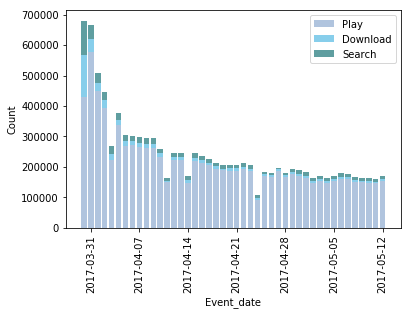

In [12]:
plt.bar(dates, P_count, width=0.8, label='Play', color='#B0C4DE')
plt.bar(dates, D_count, width=0.8, label='Download', color='#87CEEB', bottom=P_count)
plt.bar(dates, S_count, width=0.8, label='Search', color='#5F9EA0', bottom=P_count+D_count)

plt.xticks(rotation='vertical')
plt.ylabel('Count')
plt.xlabel('Event_date')
plt.legend(loc='best')

plt.show()

# Label definition

In [13]:
import datetime
from dateutil import parser

label_window_size = 14
label_window_end_date = parser.parse('2017-05-12').date()
label_window_start_date = label_window_end_date - datetime.timedelta(label_window_size-1)
print('label window:',label_window_start_date,'~',label_window_end_date,'days:',label_window_size)

feature_window_size = 30
feature_window_end_date = label_window_start_date - datetime.timedelta(1)
feature_window_start_date = feature_window_end_date  - datetime.timedelta(feature_window_size - 1)
print('feature window:',feature_window_start_date,'~',feature_window_end_date,'days:',feature_window_size)

label window: 2017-04-29 ~ 2017-05-12 days: 14
feature window: 2017-03-30 ~ 2017-04-28 days: 30


In [14]:
# all the uid we will model
df_model_uid = df.filter((F.col('date') >= feature_window_start_date) & \
                        (F.col('date') <= feature_window_end_date)) \
                        .select('uid').distinct()

# active in label window (active label=0)
df_active_uid_in_label_window = df.filter((F.col('date') >= label_window_start_date) & \
                                         (F.col('date') <= label_window_end_date)) \
                                        .select('uid').distinct().withColumn('label', F.lit(0))


In [15]:
# prepare label data (churn label=1; active label=0)
df_label = df_model_uid.join(df_active_uid_in_label_window, on=['uid'],how='left')
df_label = df_label.fillna(1)

In [16]:
df_label.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|36041|
|    0|21536|
+-----+-----+



# Feature generation

In [17]:
# event_data in feature_window
df_feature_window = df.filter((F.col('date') >= feature_window_start_date) & \
                             (F.col('date') <= feature_window_end_date))

## Frequency features

In [18]:
# define a function to generate frequency features for a list of time windows
# using when().otherwise(), and list comprehension trick!
def frequency_feature_generation_time_windows(df,event,time_window_list,snapshot_date):
    """
    generate frequency features for one event type and a list of time windows
    """
    df_feature = df \
        .filter(F.col('event')==event) \
        .groupBy('uid') \
        .agg(*[F.sum(F.when((F.col('date')>=snapshot_date-datetime.timedelta(time_window-1)) & \
                            (F.col('date')<=snapshot_date),1).otherwise(0))\
               .alias('freq_'+event+'_last_'+str(time_window)) \
                for time_window in time_window_list]
            )# *[] opens list and make them comma separated
    return df_feature

In [19]:
# generate frequency features for all event_list, time_window_list
event_list = ['P','D','S']
time_window_list = [1,3,7,14,30]
snapshot_date = feature_window_end_date
df_feature_list = []
for event in event_list:
    df_feature_list.append(frequency_feature_generation_time_windows(df_feature_window,event,
                                                                     time_window_list,snapshot_date))

## Recency features

In [20]:
# defined as days from last event
# can generate one feature for each type of event

from datetime import timedelta
def recency_feature_generation_time_windows(df,event,snapshot_date):
    """
    defined as days from last event, generate one feature for each type of event
    """
    df_feature = df \
        .filter(F.col('event')==event) \
        .groupBy('uid') \
        .agg(F.datediff(F.lit(snapshot_date), F.max(F.col('date'))).alias('rec_' + event) 
            ) 
    return df_feature

In [21]:
# # defined as days from last event
# # can generate one feature for each type of event
# def recency_feature_generation(df, event, snapshot_date):
#     """
#     defined as days from last event, generate one feature for each type of event
#     """
#     df_feature = df.filter(F.col('event')==event)\
#                 .withColumn('feature_window_end_date',F.lit(feature_window_end_date)) \
#                 .withColumn('length', F.datediff(F.col('feature_window_end_date'),F.col('date'))) \
#                 .groupBy('uid') \
#                 .agg(F.min(F.col('length')).alias('last_'+event+'_from_now'))
#     return df_feature

In [22]:
event_list = ['P', 'S', 'D']
snapshot_date = feature_window_end_date
for event in event_list:
    df_feature_list.append(recency_feature_generation_time_windows(df_feature_window,event,snapshot_date))

## Acceleration Feature

To be added at the end of this file 

## Life length feature

In [23]:
def life_length_feature_generation(df, snapshot_date):
    df_feature = df.withColumn('feature_window_end_date',F.lit(snapshot_date)) \
                .withColumn('length', F.datediff(F.col('feature_window_end_date'),F.col('date'))+1) \
                .groupBy('uid') \
                .agg(F.max(F.col('length')).alias('user_life_length'))
    return df_feature

In [24]:
snapshot_date = feature_window_end_date
df_feature_list.append(life_length_feature_generation(df_feature_window,snapshot_date))

#### Import play_ds.csv. Generate features regarding to users' music play behavior. 

In [25]:
df_play = spark.read.csv('../data/play_ds.csv',header=True)
df_play.show(3)

+---------+------+--------+----------+---------+-----------+
|      uid|device| song_id|      date|play_time|song_length|
+---------+------+--------+----------+---------+-----------+
|168551247|    ar|11881432|2017-03-30|       78|        149|
|168551026|    ar|19477157|2017-03-30|        2|         31|
|168551430|    ar| 1179220|2017-03-30|      231|        231|
+---------+------+--------+----------+---------+-----------+
only showing top 3 rows



In [26]:
# do not change it. copy it.
df_play_feature_window = df_play.filter((F.col('date')>=feature_window_start_date) & \
                                        (F.col('date')<=feature_window_end_date))

In [27]:
df_play_feature_window.show(5)

+---------+------+--------+----------+---------+-----------+
|      uid|device| song_id|      date|play_time|song_length|
+---------+------+--------+----------+---------+-----------+
|168551247|    ar|11881432|2017-03-30|       78|        149|
|168551026|    ar|19477157|2017-03-30|        2|         31|
|168551430|    ar| 1179220|2017-03-30|      231|        231|
|168548714|    ar|23492572|2017-03-30|        2|        359|
|168550890|    ar|23491657|2017-03-30|      330|        331|
+---------+------+--------+----------+---------+-----------+
only showing top 5 rows



### Music Play Data cleansing

In [28]:
df_play_feature_window # check data types

DataFrame[uid: string, device: string, song_id: string, date: string, play_time: string, song_length: string]

* #### Data type transform: date, play_time, song_length

In [29]:
df_play_feature_window = df_play_feature_window.withColumn('date', F.col('date').cast('date')) \
            .withColumn('play_time', F.col('play_time').cast('float')) \
            .withColumn('song_length', F.col('song_length').cast('float'))

In [30]:
df_play_feature_window.describe().show()

+-------+--------------------+-------+--------------------+--------------------+-------------------+
|summary|                 uid| device|             song_id|           play_time|        song_length|
+-------+--------------------+-------+--------------------+--------------------+-------------------+
|  count|             7268954|7268954|             7265746|             7226717|            7268383|
|   mean|1.6641052590015084E8|   null|1.483127549424431...|  -12718.24215184654|-1550.1050313676185|
| stddev|1.4670271592272889E7|   null|3.996608985004891...|3.8142818609771416E7| 2060490.1692335554|
|    min|           100102865|     ar|                  -1|      -1.02297313E11|      -2.14748365E9|
|    max|            99899327|     ip|             9999679|        2.14748365E9|        6.2372864E7|
+-------+--------------------+-------+--------------------+--------------------+-------------------+



* #### Notice that minimum of play_time, mean and minimun of song_length are negative which are systematic errors. We need to take care of these records.

In [31]:
print('The number of rows song_length less than 0 is %d' \
      % df_play_feature_window.filter(F.col('song_length') < 0).count() )

print('The number of rows song_length equal to 0 is %d' \
      % df_play_feature_window.filter(F.col('song_length') == 0).count() )

print('The number of rows song_length is null is %d' \
      % df_play_feature_window.filter(F.col('song_length').isNull()).count() )

print('The number of rows is %d' % df_play_feature_window.count())

The number of rows song_length less than 0 is 811
The number of rows song_length equal to 0 is 544906
The number of rows song_length is null is 571
The number of rows is 7268954


In [32]:
print('The number of rows play_time less than 0 is %d' \
      % df_play_feature_window.filter(F.col('play_time') < 0).count() )

print('The number of rows play_time equal to 0 is %d' \
      % df_play_feature_window.filter(F.col('play_time') == 0).count() )

print('The number of rows play_time is null is %d' \
      % df_play_feature_window.filter(F.col('play_time').isNull()).count() )

The number of rows play_time less than 0 is 12
The number of rows play_time equal to 0 is 1295848
The number of rows play_time is null is 42237


* #### Negative play_time and song_length proportion is very low, we could remove them directly.

In [33]:
df_play_feature_window = df_play_feature_window.filter((F.col('play_time') >= 0) & \
                                                      (F.col('song_length') >= 0))

In [34]:
df_play_feature_window_tmp = df_play_feature_window.select('uid','play_time').distinct() \
                                         .filter(F.col('play_time')>0)

* #### Remove the play_time that is longer than song_length. Treat them as unknown systematic errors.

In [35]:
df_play_feature_window = df_play_feature_window.filter(F.col('play_time') <= F.col('song_length'))

In [36]:
df_play_feature_window.describe().show()

+-------+--------------------+-------+--------------------+------------------+------------------+
|summary|                 uid| device|             song_id|         play_time|       song_length|
+-------+--------------------+-------+--------------------+------------------+------------------+
|  count|             6773363|6773363|             6770726|           6773363|           6773363|
|   mean|1.6655310949417964E8|   null|1.591561676519944...|140.38410883025446|474.03365546230054|
| stddev|   1.4168171907547E7|   null|4.140129542749149...|186.88703515722113|115648.65765178896|
|    min|           100102865|     ar|                  -1|               0.0|               0.0|
|    max|            99899327|     ip|             9999679|           22847.0|       6.2372864E7|
+-------+--------------------+-------+--------------------+------------------+------------------+



In [37]:
# Replace play_time equal to zero with median_play_time. Do the same to song_length.
# median_play_time = df_play_feature_window.approxQuantile('play_time', [0.5], 0.25)
# median_song_length = df_play_feature_window.approxQuantile('song_length', [0.5], 0.25)
# # median_play_time, median_song_length

# df_play_feature_window = df_play_feature_window.withColumn('play_time', 
#                                     F.when(df_play_feature_window['play_time']==0, median_play_time[0])
#                                     .otherwise(df_play_feature_window['play_time']))
                      
# df_play_feature_window = df_play_feature_window.withColumn('song_length', 
#                                     F.when(df_play_feature_window['song_length']==0, median_song_length[0])
#                                     .otherwise(df_play_feature_window['song_length']))                                        

## User profile feature

In [38]:
df_profile_tmp = df_play_feature_window.select('uid','device').distinct()

In [39]:
df_profile = df_label.select('uid').join(df_profile_tmp.select('uid','device'),on='uid',how='left')
df_profile.groupBy('device').count().show()

+------+-----+
|device|count|
+------+-----+
|  null| 1456|
|    ar|49026|
|    ip| 7104|
+------+-----+



In [40]:
# check if one user has two devices. Result shows each user uses one device.
df_profile_tmp.count(), df_profile_tmp.distinct().count()

(56130, 56130)

#### User device missing data inputation by create a new level
Combine `wp` with `no device`, since number of `wp` is small.

In [41]:
df_profile = df_profile.fillna({'device': 'other'})

df_profile = df_profile.withColumn('device', F.when(df_profile['device'] == 'wp', 'other')
                                   .otherwise(df_profile['device']))

In [42]:
df_profile.groupBy('device').count().show()

+------+-----+
|device|count|
+------+-----+
| other| 1456|
|    ar|49026|
|    ip| 7104|
+------+-----+



## Music play counts features
How many times user playing the songs in a given time window.

In [43]:
df_play_counts = df_label.select('uid').join(df_play_feature_window.select('uid', 'date', 'play_time', 'song_length'), on='uid', how='left')
# df_play_counts.describe().show()

In [44]:
# count missing values
# df_play_counts.select(*[F.sum(F.col(c).isNull().cast("int")).alias(c) \
#                         for c in df_play_counts.columns]).show()

In [45]:
def play_counts_feature_generation_time_windows(df,time_window_list,snapshot_date):
    """
    generate total song play time features (using play_ds data) for different time window
    """
    df_feature = df \
        .groupBy('uid') \
        .agg(*[F.sum(F.when((F.col('date')>=snapshot_date-datetime.timedelta(time_window-1)) \
                            & (F.col('date')<=snapshot_date),1).otherwise(0))\
               .alias('play_counts_last_'+str(time_window)) \
                for time_window in time_window_list]
            )# *[] opens list and make them comma separated
    return df_feature

In [46]:
# all time windows 
time_window_list = [1,3,7,14,30]
snapshot_date = feature_window_end_date

df_feature_list.append(play_counts_feature_generation_time_windows(df_play_counts,
                                                                     time_window_list,snapshot_date))

Total length of music playback by user, in a given time window

In [47]:
# function for generating Total length of music playback by user, in a given time window 

def playtime_feature_generation(df,time_window,snapshot_date):
    """
    generate playtime features for one time window
    """   
    # then filter by date. Date should be ending at a given data , and start at end_date minus the window size

    # then group by uid and calculate the most recent event date (max date) 

    df_playtime = df \
        .filter((F.col('date')>=snapshot_date-datetime.timedelta(time_window-1)) & (F.col('date')<=snapshot_date)) \
        .groupBy('uid').agg(F.sum(F.col('play_time')).alias('total_len_of_playback'+'_last_'+str(time_window)))      

    return df_playtime

In [48]:
# for different time window 
time_window_list = [1,3,7,14,30]
for time_window in time_window_list:
    df_feature_list.append(playtime_feature_generation(df_play_counts,time_window,snapshot_date))

### Songs fully played

In [49]:
df_play_feature_window

DataFrame[uid: string, device: string, song_id: string, date: date, play_time: float, song_length: float]

In [50]:

# using play data (need to clean play time and song length first,
# play time may be negative in data,
# song length may be zeros)

#  uid|device|song_id|  date|play_time|song_length|

# filter play time that are not positive
df_songs_length = df_play_feature_window.select('uid','play_time','song_length').distinct() \
                         .filter((F.col('play_time')>0) & (F.col('song_length')>0)) \
                         .withColumn("percent",F.col('play_time')/F.col('song_length'))

In [51]:
# Generate counts of songs play 80% of their song length (using play_ds data) for different time window
    

# function for generating songs play 80% of their song length by user, in a given time window 

def songs_feature_generation(df,time_window,snapshot_date):
    """
    generate songs count features for one event type and one time window
    """   
    #  filter by date. Date should be ending at a given data , and start at end_date minus the window size
    
    # filter by percent, should be bigger than 0.8
    # aggregate the number of songs per user

    df_songs = df \
        .filter((F.col('date')>=snapshot_date-datetime.timedelta(time_window-1)) & (F.col('date')<=snapshot_date)) \
        .filter(F.col('percent')>=0.8) \
        .groupBy('uid').agg(F.count(F.col('uid')).alias('playback_80%len_counts'+'_last_'+str(time_window)))      


    return df_songs

In [52]:
# for different time window 
time_window_list = [1,3,7,14,30]
for time_window in time_window_list:
    df_feature_list.append(songs_feature_generation(df_songs_length,time_window,snapshot_date))

### Mean play percentage feature

In [53]:
# Generate average songs played progress (using play_ds data) for different time window
    

# function for generating average of the songs played progress , in a given time window 

def song_percent_feature_generation(df,time_window,snapshot_date):
    """
    generate average songs played progress features for one time window
    """   
    #  filter by date. Date should be ending at a given data , and start at end_date minus the window size
    
    # 
    # then group by uid and calculate the most recent event date (max date) 

    df_songs_percent = df \
        .filter((F.col('date')>=snapshot_date-datetime.timedelta(time_window-1)) & (F.col('date')<=snapshot_date)) \
        .groupBy('uid').agg(F.mean(F.col('percent')).alias('mean_percent'+'_last_'+str(time_window)))      


    return df_songs_percent

In [54]:
# for different time window 
time_window_list = [1,3,7,14,30]
for time_window in time_window_list:
    df_feature_list.append(song_percent_feature_generation(df_songs_length,time_window,snapshot_date))

### Standard deviation play percentage feature

In [55]:
# Generate the sd of songs played progress (using play_ds data) for different time window
    
# function for generating sd of the songs played progress , in a given time window 

def song_sd_feature_generation(df,time_window,snapshot_date):
    """
    generate sd songs played progress features for one time window
    """   
    #  filter by date. Date should be ending at a given data , and start at end_date minus the window size
    
    # 
    # then group by uid and calculate the most recent event date (max date) 

    df_songs_sd = df \
        .filter((F.col('date')>=snapshot_date-datetime.timedelta(time_window-1)) & (F.col('date')<=snapshot_date)) \
        .groupBy('uid').agg(F.stddev(F.col('percent')).alias('sd_percent'+'_last_'+str(time_window)))      


    return df_songs_sd

In [56]:
# for different time window 
time_window_list = [1,3,7,14,30]
for time_window in time_window_list:
    df_feature_list.append(song_sd_feature_generation(df_songs_length,time_window,snapshot_date))

## Form training data

In [57]:
def join_feature_data(df_master, df_feature_list):
    for df_feature in df_feature_list:
        df_master = df_master.join(df_feature,on='uid',how='left')
        df_master.persist()
    return df_master        

In [58]:
# join all behavior features
df_model_final = join_feature_data(df_label,df_feature_list)

In [59]:
# join all profile features
# df_model_final = join_feature_data(df_model_final,df_new_features_list)
df_model_final = join_feature_data(df_model_final,[df_profile])

### Acceleration

In [60]:
# play_1d_over_play_7d
# play_1d_over_down_1d
# play_1d_over_down_7d

# play_1d_over_search_1d
# play_1d_over_search_7d

df_model_final = df_model_final.withColumn('play_1_over_play_7', F.col('freq_P_last_1')/F.col('freq_P_last_7')) \
                                .withColumn('play_1_over_down_1', F.col('freq_P_last_1')/F.col('freq_D_last_1')) \
                                .withColumn('play_1_over_down_7', F.col('freq_P_last_1')/F.col('freq_D_last_7')) \
                                .withColumn('play_1_over_search_1', F.col('freq_P_last_1')/F.col('freq_S_last_1')) \
                                .withColumn('play_1_over_search_7', F.col('freq_P_last_1')/F.col('freq_S_last_7'))

In [61]:
df_model_final = df_model_final.fillna(0).toPandas()

Encode categorical columns to numerical values

In [62]:
df_dummies = pd.get_dummies(df_model_final['device'])

In [63]:
df_model_final = df_model_final.join(df_dummies)
df_model_final = df_model_final.drop('device', axis=1)

## save to csv

In [64]:
df_model_final.to_csv('../data/df_model_final3.csv',index=False)

In [65]:
df_model_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57586 entries, 0 to 57585
Data columns (total 54 columns):
uid                               57586 non-null object
label                             57586 non-null int64
freq_P_last_1                     57586 non-null int64
freq_P_last_3                     57586 non-null int64
freq_P_last_7                     57586 non-null int64
freq_P_last_14                    57586 non-null int64
freq_P_last_30                    57586 non-null int64
freq_D_last_1                     57586 non-null int64
freq_D_last_3                     57586 non-null int64
freq_D_last_7                     57586 non-null int64
freq_D_last_14                    57586 non-null int64
freq_D_last_30                    57586 non-null int64
freq_S_last_1                     57586 non-null int64
freq_S_last_3                     57586 non-null int64
freq_S_last_7                     57586 non-null int64
freq_S_last_14                    57586 non-null int64
freq_S_las

### EDA

#### (1) Numeric variables including both feature and response

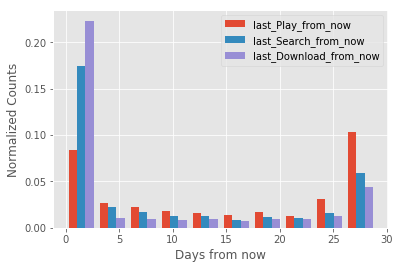

In [49]:
labels = ['last_Play_from_now', 'last_Search_from_now', 'last_Download_from_now']
plt.hist([df_model_final['last_P_from_now'], \
          df_model_final['last_S_from_now'], \
         df_model_final['last_D_from_now']], normed=True, label=labels)
plt.legend(loc='best')
plt.xlabel('Days from now')
plt.ylabel('Normalized Counts')
plt.show()

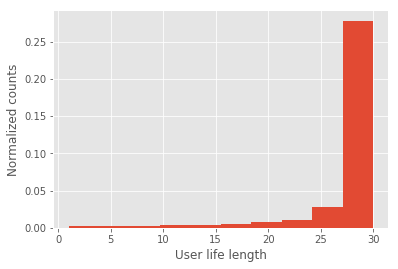

In [50]:
plt.hist(df_model_final['user_life_length'], normed=True)
plt.xlabel('User life length')
plt.ylabel('Normalized counts')
plt.show()

#### (2) Categorical variables including both feature and response

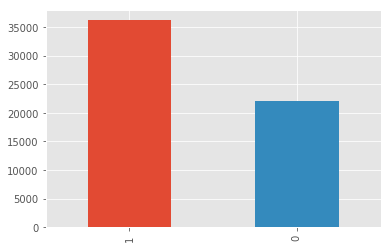

In [51]:
df_model_final['label'].value_counts().plot.bar()
plt.show()

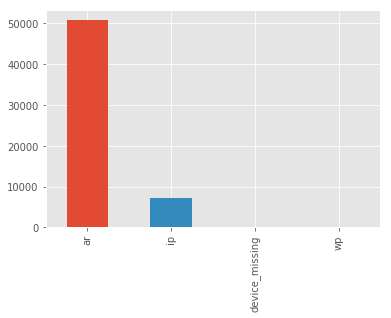

In [52]:
df_model_final['device'].value_counts().plot.bar()
plt.show()

#### (3) Numeric variable with categorical response

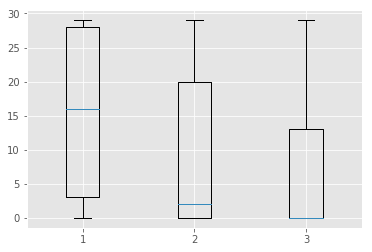

In [53]:
plt.boxplot((df_model_final['last_P_from_now'], \
          df_model_final['last_S_from_now'], \
         df_model_final['last_D_from_now']))
plt.show()

many features are correlated due to generation

In [54]:
import seaborn as sns
sns.set(style="white")

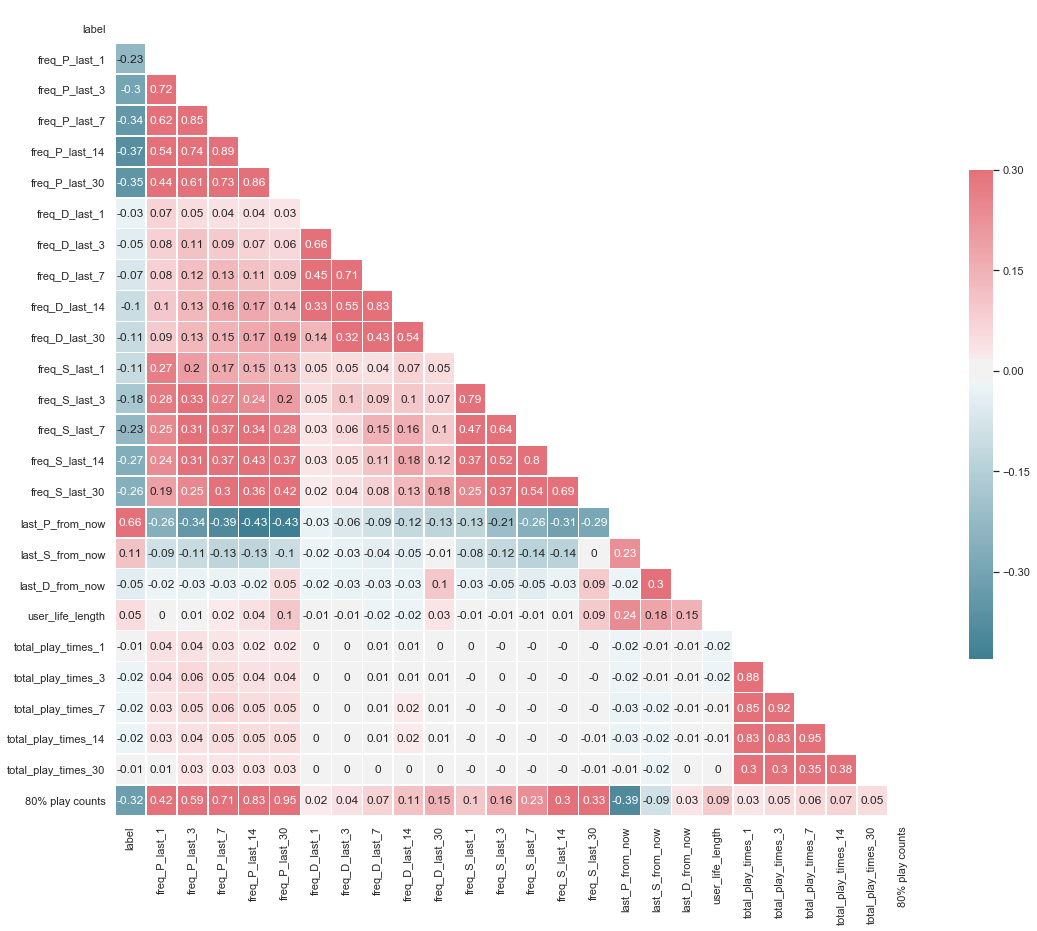

In [55]:
# Compute the correlation matrix
corr = df_model_final.corr().round(2)
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18,18))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

explore churn rate with label

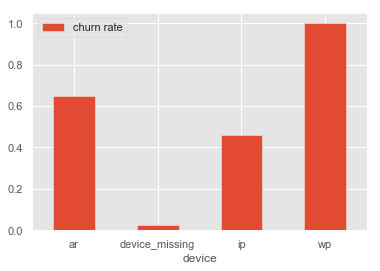

In [64]:
plt.style.use('ggplot')
df_model_final[['device', 'label']].groupby(['device']).mean().plot.bar()
plt.xticks(rotation='horizontal')
plt.legend(loc='best')
L=plt.legend()
L.get_texts()[0].set_text('churn rate')
plt.show()

In [77]:
def hist_active_vs_churn(df, col_name):
    is_active = df['label'] == 0
    fig, axes = plt.subplots(nrows=1, ncols=2)
    axes[0].hist(df[is_active][col_name].values, normed=True)
    axes[1].hist(df[~is_active][col_name].values, normed=True)
    axes[0].set_title('active users')
    axes[0].set_xlabel(col_name)
    axes[0].set_ylabel('normalized counts')
    axes[1].set_title('churned users')
    axes[1].set_xlabel(col_name)
    axes[1].set_ylabel('normalized counts')
    
    fig.tight_layout()
    plt.show()

In [63]:
df_model_final.columns

Index(['uid', 'label', 'freq_P_last_1', 'freq_P_last_3', 'freq_P_last_7',
       'freq_P_last_14', 'freq_P_last_30', 'freq_D_last_1', 'freq_D_last_3',
       'freq_D_last_7', 'freq_D_last_14', 'freq_D_last_30', 'freq_S_last_1',
       'freq_S_last_3', 'freq_S_last_7', 'freq_S_last_14', 'freq_S_last_30',
       'last_P_from_now', 'last_S_from_now', 'last_D_from_now',
       'user_life_length', 'device', 'play_time_last_1', 'play_time_last_3',
       'play_time_last_7', 'play_time_last_14', 'play_time_last_30',
       'rela_freq_last_1', 'rela_freq_last_3', 'rela_freq_last_7',
       'rela_freq_last_14', 'rela_freq_last_30', 'play_1_over_play_7',
       'play_1_over_down_1', 'play_1_over_down_7', 'play_1_over_search_1',
       'play_1_over_search_7'],
      dtype='object')

In [75]:
col_names = ['freq_P_last_1', 'freq_P_last_3', 'freq_P_last_7',
       'freq_P_last_14', 'freq_P_last_30', 'freq_D_last_1', 'freq_D_last_3',
       'freq_D_last_7', 'freq_D_last_14', 'freq_D_last_30', 'freq_S_last_1',
       'freq_S_last_3', 'freq_S_last_7', 'freq_S_last_14', 'freq_S_last_30',
       'last_P_from_now', 'last_S_from_now', 'last_D_from_now',
       'user_life_length', 'total_play_times_1', 'total_play_times_3',
       'total_play_times_7', 'total_play_times_14', 'total_play_times_30',
       '80% play counts']

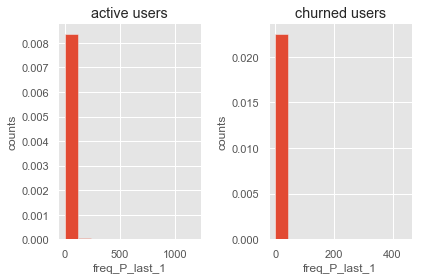

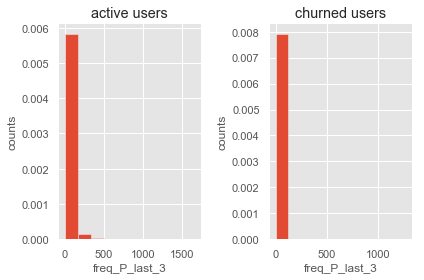

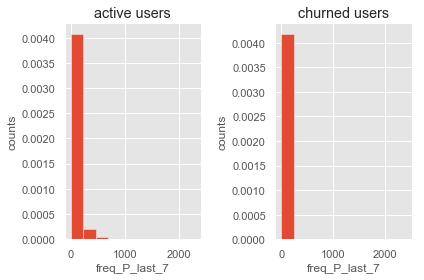

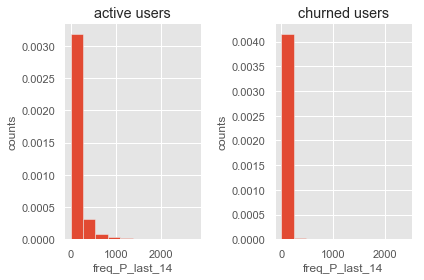

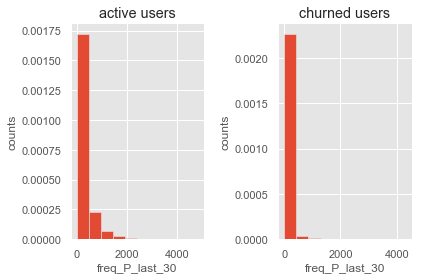

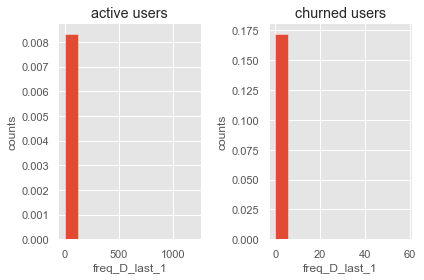

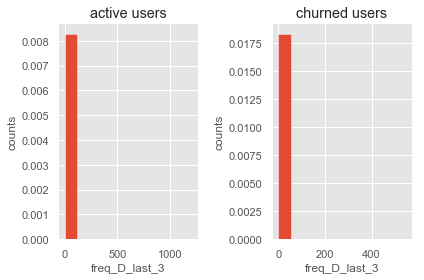

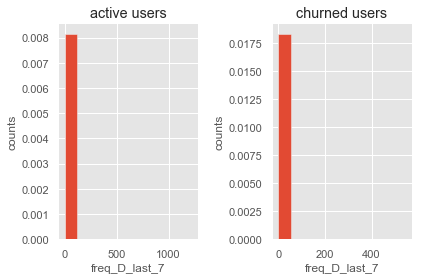

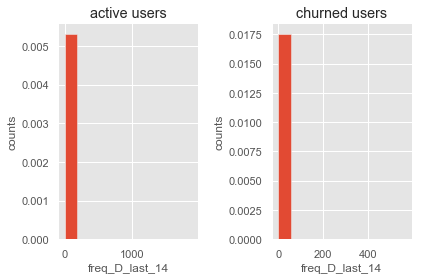

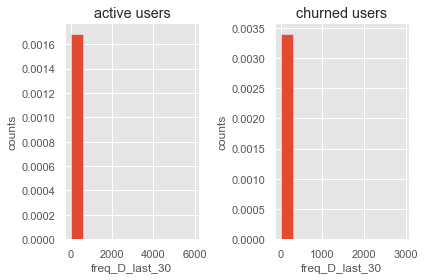

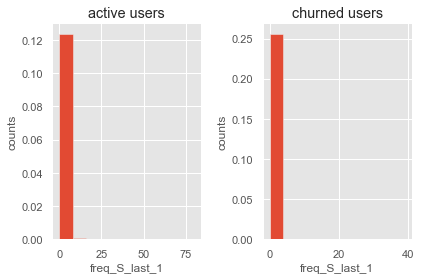

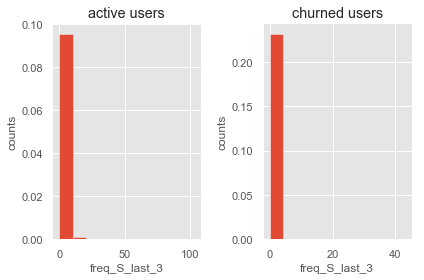

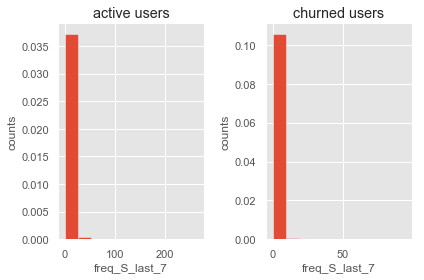

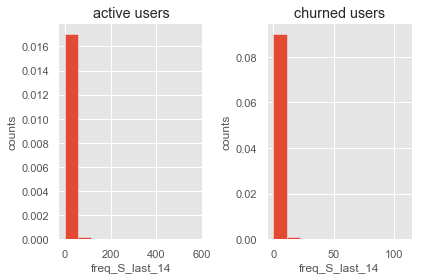

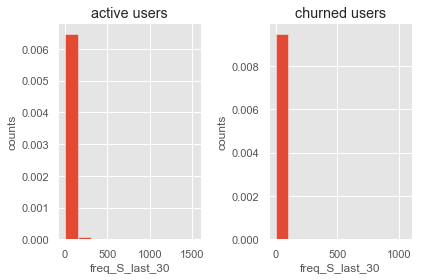

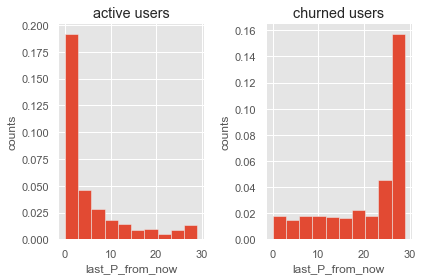

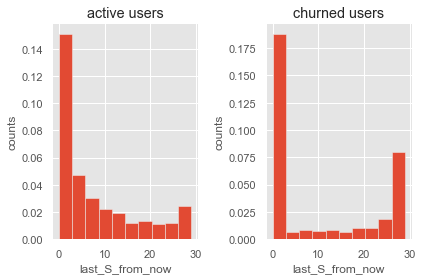

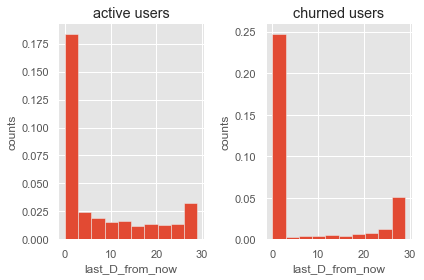

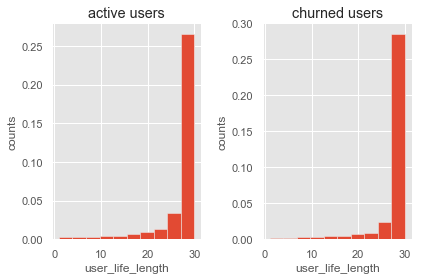

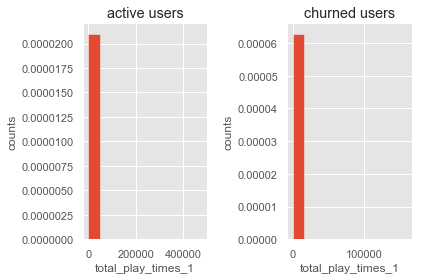

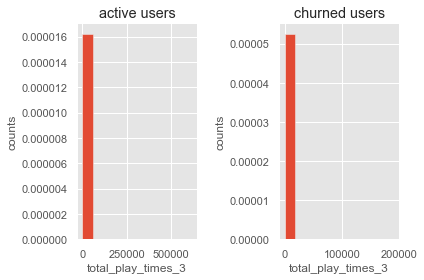

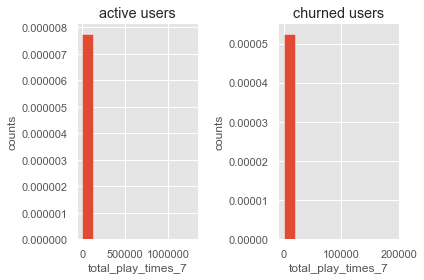

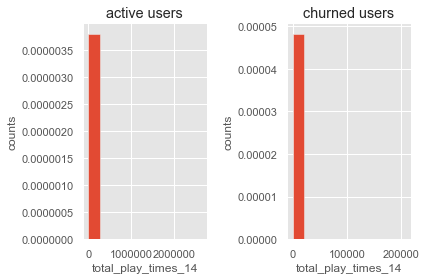

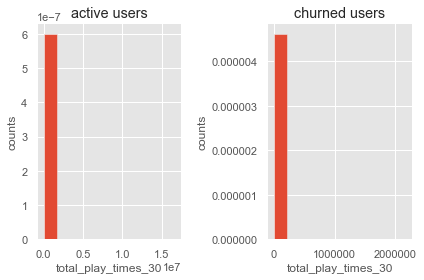

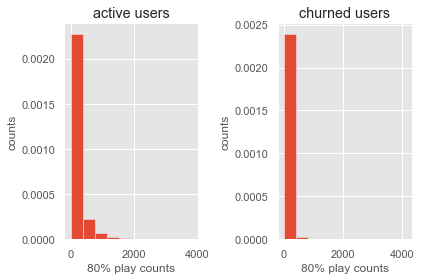

In [76]:
for col in col_names:
    hist_active_vs_churn(df_model_final, col)

In [68]:
df_model_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58212 entries, 0 to 58211
Data columns (total 37 columns):
uid                     58212 non-null object
label                   58212 non-null int64
freq_P_last_1           58212 non-null int64
freq_P_last_3           58212 non-null int64
freq_P_last_7           58212 non-null int64
freq_P_last_14          58212 non-null int64
freq_P_last_30          58212 non-null int64
freq_D_last_1           58212 non-null int64
freq_D_last_3           58212 non-null int64
freq_D_last_7           58212 non-null int64
freq_D_last_14          58212 non-null int64
freq_D_last_30          58212 non-null int64
freq_S_last_1           58212 non-null int64
freq_S_last_3           58212 non-null int64
freq_S_last_7           58212 non-null int64
freq_S_last_14          58212 non-null int64
freq_S_last_30          58212 non-null int64
last_P_from_now         58212 non-null int64
last_S_from_now         58212 non-null int64
last_D_from_now         58212 non-n